In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
from pylab import rcParams

rcParams['figure.figsize'] = 20, 6
rcParams['axes.grid'] = True

<span style="font-size: 24px;">**Autocorrelation Function / Partial Autocorrelation Function**</span>

In [3]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols

# non-stationary dataset
df1 = pd.read_csv('../meta/airline_passengers.csv',index_col='Month',parse_dates=True)
df1.index.freq = 'MS'

# stationary dataset
df2 = pd.read_csv('../meta/DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df2.index.freq = 'D'

<span style="font-size: 18px;">**Autocovariance for 1D**</span>

In a **deterministic** process, like $y=sin(x)$, we always know the value of $y$ for a given value of $x$. However, in a **stochastic** process there is always some randomness that prevents us from knowing the value of $y$. Instead, we analyze the past (or **lagged**) behavior of the system to derive a probabilistic estimate for $\hat{y}$.

One useful descriptor is **covariance**. When talking about dependent and independent $x$ and $y$ variables, covariance describes how the variance in $x$ relates to the variance in $y$. Here the size of the covariance isn't really important, as $x$ and $y$ may have very different scales. However, if the covariance is positive it means that $x$ and $y$ are changing in the same direction, and may be related.

With a time series, $x$ is a fixed interval. Here we want to look at the variance of $y_t$ against lagged or shifted values of $y_{t+k}$

For a stationary time series, the autocovariance function for $\gamma$ (gamma) is given as:

${\displaystyle {\gamma}_{XX}(t_{1},t_{2})=\operatorname {Cov} \left[X_{t_{1}},X_{t_{2}}\right]=\operatorname {E} [(X_{t_{1}}-\mu _{t_{1}})(X_{t_{2}}-\mu _{t_{2}})]}$

We can calculate a specific $\gamma_k$ with:

${\displaystyle \gamma_k = \frac 1 n \sum\limits_{t=1}^{n-k} (y_t - \bar{y})(y_{t+k}-\bar{y})}$

Autocovariance Example:

Say we have a time series with five observations: {13, 5, 11, 12, 9}.<br>
We can quickly see that $n = 5$, the mean $\bar{y} = 10$, and we'll see that the variance $\sigma^2 = 8$.<br>
The following calculations give us our covariance values:
<br><br>
$\gamma_0 = \frac {(13-10)(13-10)+(5-10)(5-10)+(11-10)(11-10)+(12-10)(12-10)+(9-10)(9-10)} 5 = \frac {40} 5 = 8.0 \\
\gamma_1 = \frac {(13-10)(5-10)+(5-10)(11-10)+(11-10)(12-10)+(12-10)(9-10)} 5 = \frac {-20} 5 = -4.0 \\
\gamma_2 = \frac {(13-10)(11-10)+(5-10)(12-10)+(11-10)(9-10)} 5 = \frac {-8} 5 = -1.6 \\
\gamma_3 = \frac {(13-10)(12-10)+(5-10)(9-10)} 5 = \frac {11} 5 = 2.2 \\
\gamma_4 = \frac {(13-10)(9-10)} 5 = \frac {-3} 5 = -0.6$
<br><br>
Note that $\gamma_0$ is just the population variance $\sigma^2$

Let's see if statsmodels gives us the same results! For this we'll create a **fake** dataset:

In [4]:
df = pd.DataFrame({'a':[13, 5, 11, 12, 9]})
arr = acovf(df['a'])
arr

array([ 8. , -4. , -1.6,  2.2, -0.6])

<span style="font-size: 18px;">**Unbiased Autocovariance**</span>

Note that the number of terms in the calculations above are decreasing.<br>Statsmodels can return an "unbiased" autocovariance where instead of dividing by $n$ we divide by $n-k$.

$\gamma_0 = \frac {(13-10)(13-10)+(5-10)(5-10)+(11-10)(11-10)+(12-10)(12-10)+(9-10)(9-10)} {5-0} = \frac {40} 5 = 8.0 \\
\gamma_1 = \frac {(13-10)(5-10)+(5-10)(11-10)+(11-10)(12-10)+(12-10)(9-10)} {5-1} = \frac {-20} 4 = -5.0 \\
\gamma_2 = \frac {(13-10)(11-10)+(5-10)(12-10)+(11-10)(9-10)} {5-2} = \frac {-8} 3 = -2.67 \\
\gamma_3 = \frac {(13-10)(12-10)+(5-10)(9-10)} {5-3} = \frac {11} 2 = 5.5 \\
\gamma_4 = \frac {(13-10)(9-10)} {5-4} = \frac {-3} 1 = -3.0$

In [5]:
arr2 = acovf(df['a'],unbiased=True)
arr2

array([ 8.        , -5.        , -2.66666667,  5.5       , -3.        ])

<span style="font-size: 18px;">**Autocorrelation for 1D**</span>

The correlation $\rho$ (rho) between two variables $y_1,y_2$ is given as:

$\rho = \frac {\operatorname E[(y_1−\mu_1)(y_2−\mu_2)]} {\sigma_{1}\sigma_{2}} = \frac {\operatorname {Cov} (y_1,y_2)} {\sigma_{1}\sigma_{2}}$,

where $E$ is the expectation operator, $\mu_{1},\sigma_{1}$ and $\mu_{2},\sigma_{2}$ are the means and standard deviations of $y_1$ and $y_2$.

When working with a single variable (i.e. `autocorrelation`) we would consider $y_1$ to be the original series and $y_2$ a lagged version of it. Note that with autocorrelation we work with $\bar y$, that is, the full population mean, and `not` the means of the reduced set of lagged factors (see note below).

Thus, the formula for $\rho_k$ for a time series at lag $k$ is:

${\displaystyle \rho_k = \frac {\sum\limits_{t=1}^{n-k} (y_t - \bar{y})(y_{t+k}-\bar{y})} {\sum\limits_{t=1}^{n} (y_t - \bar{y})^2}}$

This can be written in terms of the covariance constant $\gamma_k$ as:

${\displaystyle \rho_k = \frac {\gamma_k n} {\gamma_0 n} = \frac {\gamma_k} {\sigma^2}}$

For example,<br>
$\rho_4 = \frac {\gamma_4} {\sigma^2} = \frac{-0.6} {8} = -0.075$

Note that ACF values are bound by -1 and 1. That is, ${\displaystyle -1 \leq \rho_k \leq 1}$

In [6]:
arr3 = acf(df['a'])
arr3

array([ 1.   , -0.5  , -0.2  ,  0.275, -0.075])

<span style="font-size: 18px;">**Partial Autocorrelation**</span>

Partial autocorrelations measure the linear dependence of one variable after removing the effect of other variable(s) that affect both variables. That is, the partial autocorrelation at lag $k$ is the autocorrelation between $y_t$ and $y_{t+k}$ that is not accounted for by lags $1$ through $k−1$.

A common method employs the non-recursive <a href='https://en.wikipedia.org/wiki/Autoregressive_model#Calculation_of_the_AR_parameters'>Yule-Walker Equations</a>:

$\phi_0 = 1\\
\phi_1 = \rho_1 = -0.50\\
\phi_2 = \frac {\rho_2 - {\rho_1}^2} {1-{\rho_1}^2} = \frac {(-0.20) - {(-0.50)}^2} {1-{(-0.50)}^2}= \frac {-0.45} {0.75} = -0.60$

As $k$ increases, we can solve for $\phi_k$ using matrix algebra and the <a href='https://en.wikipedia.org/wiki/Levinson_recursion'>Levinson–Durbin recursion</a> algorithm which maps the sample autocorrelations $\rho$ to a <a href='https://en.wikipedia.org/wiki/Toeplitz_matrix'>Toeplitz</a> diagonal-constant matrix. The full solution is beyond the scope of this course, but the setup is as follows:


$\displaystyle \begin{pmatrix}\rho_0&\rho_1&\cdots &\rho_{k-1}\\
\rho_1&\rho_0&\cdots &\rho_{k-2}\\
\vdots &\vdots &\ddots &\vdots \\
\rho_{k-1}&\rho_{k-2}&\cdots &\rho_0\\
\end{pmatrix}\quad \begin{pmatrix}\phi_{k1}\\\phi_{k2}\\\vdots\\\phi_{kk}\end{pmatrix}
\mathbf = \begin{pmatrix}\rho_1\\\rho_2\\\vdots\\\rho_k\end{pmatrix}$
<br><br><br>
**NOTE:** We use `method='mle'` in order to use biased ACF coefficients. "mle" stands for "maximum likelihood estimation". Alternatively we can pass `method='unbiased'` (the statsmodels default)

In [7]:
arr4 = pacf_yw(df['a'],nlags=4,method='mle')
arr4

array([ 1.        , -0.5       , -0.6       , -0.38541667, -0.40563273])

In [8]:
arr5 = pacf_yw(df['a'],nlags=4,method='unbiased')
arr5

array([ 1.        , -0.625     , -1.18803419,  2.03764205,  0.8949589 ])

<span style="font-size: 18px;">**Partial Autocorrelation with OLS**</span>

This provides partial autocorrelations with <a href='https://en.wikipedia.org/wiki/Ordinary_least_squares'>ordinary least squares</a> (OLS) estimates for each lag instead of Yule-Walker.

In [9]:
arr6 = pacf_ols(df['a'],nlags=4)
arr6

array([ 1.        , -0.49677419, -0.43181818,  0.53082621,  0.25434783])

<span style="font-size: 18px;">**Plotting**</span>

The arrays returned by `.acf(df)` and `.pacf_yw(df)` show the magnitude of the autocorrelation for a given $y$ at time $t$. Before we look at plotting arrays, let's look at the data itself for evidence of autocorrelation.

Pandas has a built-in plotting function that plots increasing $y_t$ values on the horizontal axis against lagged versions of the values $y_{t+1}$ on the vertical axis. If a dataset is non-stationary with an upward trend, then neighboring values should trend in the same way. Let's look at the **Airline Passengers** dataset first.

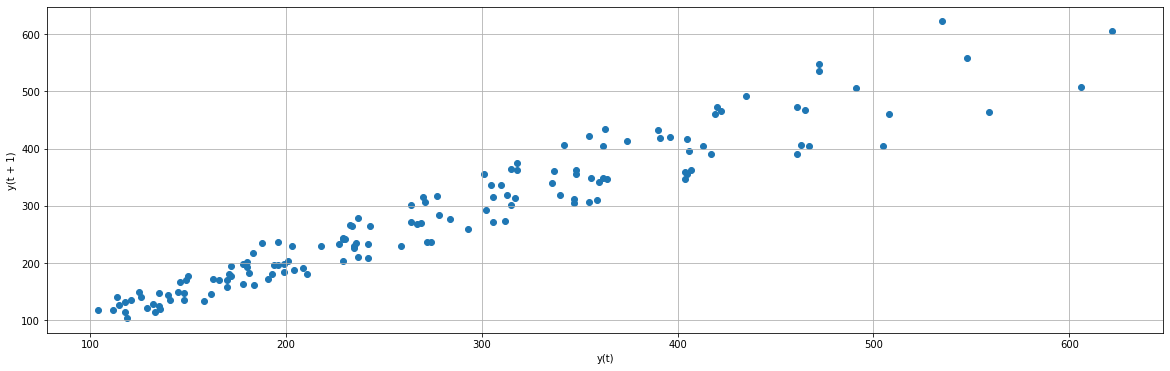

In [10]:
from pandas.plotting import lag_plot

lag_plot(df1['Thousands of Passengers']);

Visually this shows evidence of a very strong autocorrelation; as $y_t$ values increase, nearby (lagged) values also increase.

Now let's look at the stationary **Daily Total Female Births** dataset:

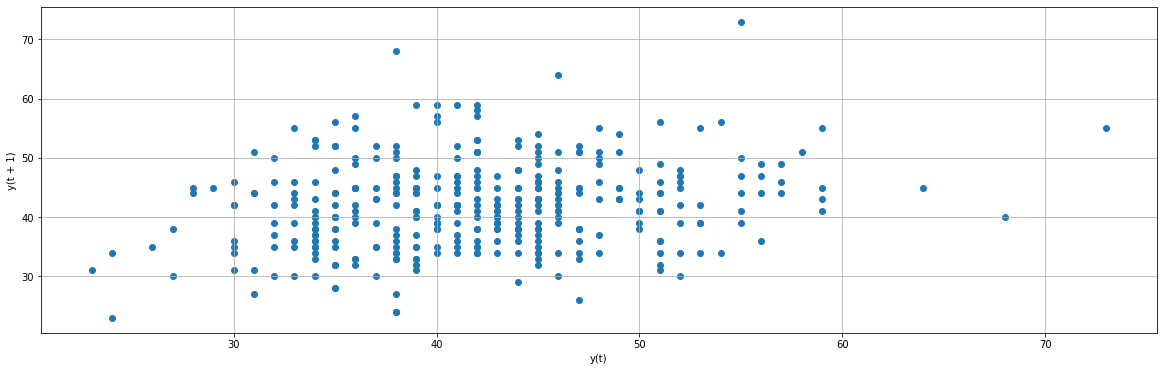

In [11]:
lag_plot(df2['Births']);

As expected, there is little evidence of autocorrelation here.

<span style="font-size: 18px;">**ACF Plots**</span>

Plotting the magnitude of the autocorrelations over the first few (20-40) lags can say a lot about a time series.

For example, consider the stationary <strong>Daily Total Female Births</strong> dataset:

In [12]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

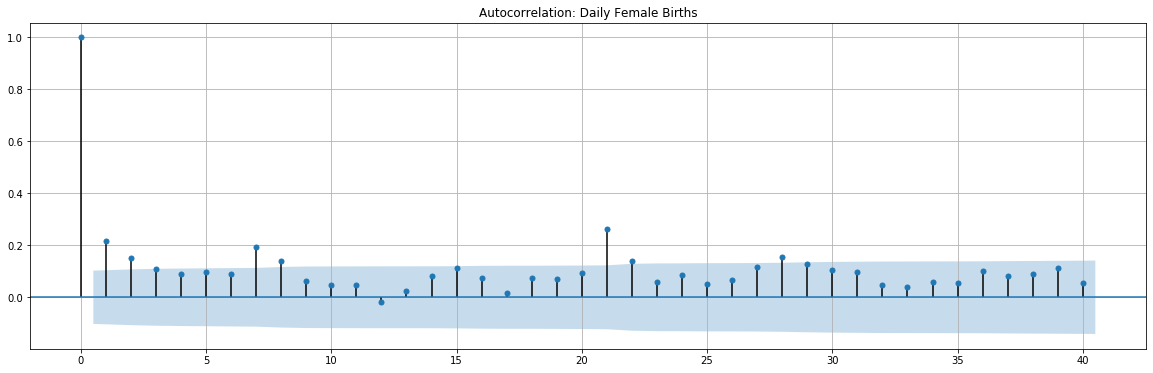

In [13]:
title = 'Autocorrelation: Daily Female Births'
lags = 40
plot_acf(df2,title=title,lags=lags);

This is a typical ACF plot for stationary data, with lags on the horizontal axis and correlations on the vertical axis. The first value $y_0$ is always 1. A sharp dropoff indicates that there is no AR component in the ARIMA model.

Next we'll look at non-stationary data with the **Airline Passengers** dataset:

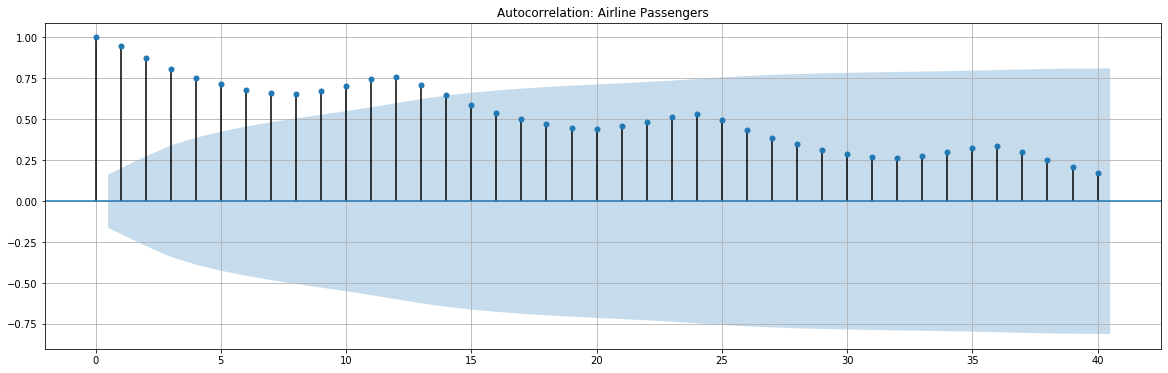

In [14]:
title = 'Autocorrelation: Airline Passengers'
lags = 40
plot_acf(df1,title=title,lags=lags);

This plot indicates non-stationary data, as there are a large number of lags before ACF values drop off.

<span style="font-size: 18px;">**PACF Plots**</span>

Partial autocorrelations work best with stationary data. Let's look first at **Daily Total Female Births**:

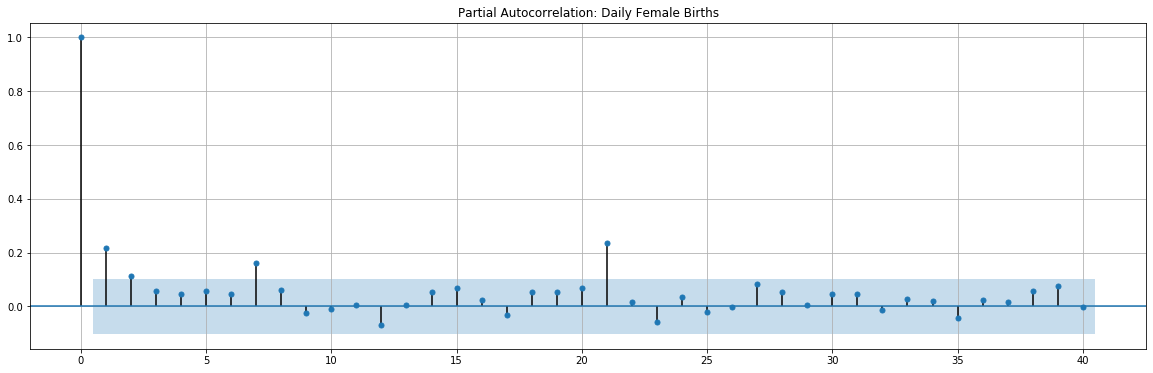

In [15]:
title='Partial Autocorrelation: Daily Female Births'
lags=40
plot_pacf(df2,title=title,lags=lags);

To make the **Airline Passengers**data stationary, we'll first apply `differencing`

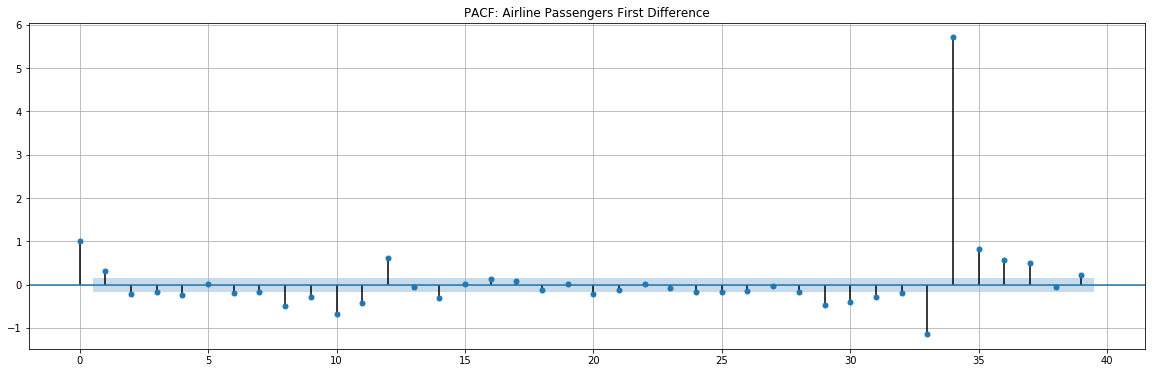

In [16]:
df1['d1'] = df1['Thousands of Passengers'].diff(1)
title='PACF: Airline Passengers First Difference'
lags=40
plot_pacf(df1['d1'].dropna(), title=title, lags=pd.np.arange(lags));